# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
import re
# import nltk
# nltk.download('stopwords')
from pymystem3 import Mystem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 

In [3]:
geo_comment = pd.read_excel('geo_comment.xlsx')
geo_comment

,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...
...,...,...,...,...,...,...
70377,70377,37.454528,55.792331,-1,1,Не поддерживаю. Я против строительства многоэт...
70378,70378,37.384325,55.899068,-1,1,Не поддерживаю. Не нужны отстойники автобусов ...
70379,70379,37.421066,55.848756,1,1,"Не поддерживаю. На мой взгляд, необходимо искл..."
70380,70380,37.448509,55.793065,-1,1,Не поддерживаю: нарушения при строительстве н...


In [4]:
geo = pd.read_excel('geo.xlsx')
geo

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1
...,...,...,...,...
108801,108801,37.454528,55.792331,-1
108802,108802,37.384325,55.899068,-1
108803,108803,37.421066,55.848756,1
108804,108804,37.448509,55.793065,-1


Задание 1:  
***Визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)***

Для решения данной задачи подойдет алгоритм K-means. Наметим примерное количество кластеров. Например, возьмем 10.

In [5]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(geo[['x', 'y']])
# Теперь сделаем случайное предсказание:
clusters_predict = kmeans.predict(geo[['x', 'y']])

In [6]:
def get_descr(algo_name, y_pred, X):
    return "{}\nSilhouette {:.2f}".format(
        algo_name,
#         adjusted_rand_score(y, y_pred),
        silhouette_score(X, y_pred)
    )

CPU times: user 17min 58s, sys: 1h 48min 28s, total: 2h 6min 26s
Wall time: 10min 21s


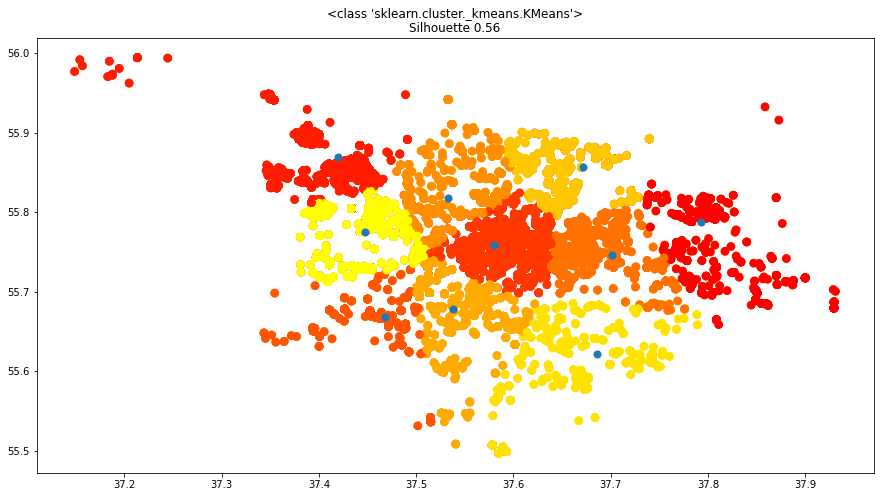

In [7]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(geo['x'], geo['y'], c=clusters_predict, cmap='autumn', s=60)
ax.set_title(get_descr("KMeans",clusters_predict, geo[['x', 'y']]))

# кластеризуем и выводим картинку
clusters = kmeans.fit_predict(geo[['x', 'y']])
ax.scatter(geo['x'], geo['y'], c=clusters, cmap='autumn', s=60)
ax.set_title(get_descr(KMeans, clusters, geo[['x', 'y']]))

# выводим центры кластеров
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], s=50)

Вот они, наши 10 кластеров с намеченными центроидами. Плотность у них разная, и это не очень хорошо. Но при этом жизненно.

Теперь посмотрим, какое оптимальное количество кластеров должно быть:

In [8]:
k_inertia = []
ks = range(2,10)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(geo[['x', 'y']])
    k_inertia.append(clf_kmeans.inertia_)
k_inertia

[952.618953110176,
 542.8435991917122,
 355.32003461983174,
 280.58395786598396,
 231.98917661262195,
 196.85252521169548,
 168.3101502667112,
 142.81827860088055]

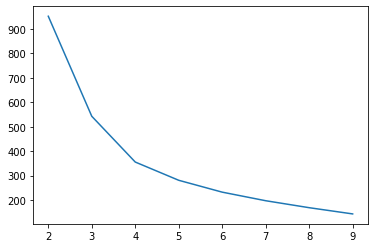

In [9]:
plt.plot(ks, k_inertia)

Можно выбрать 4 кластера.

Теперь на каждом шаге посмотрим изменение inertia.
Сперва посчитаем сами изменения:

$${inertia_{k+1}-inertia_{k}}$$

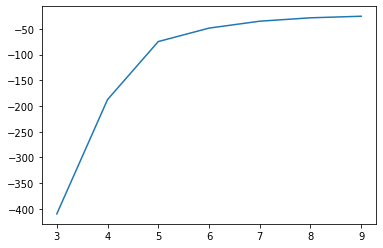

In [10]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

Здесь уже можно было бы остановиться на 5.

Но мы пойдем дальше и найдём оптимальное число кластеров:
    
$$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

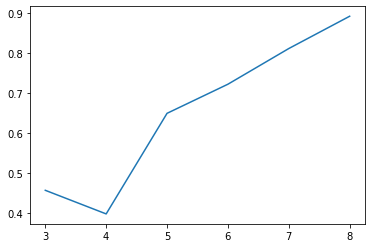

In [11]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

И оптимальное число классов:

In [12]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

4

И тут значение 4 повторяется. И хотя районов в Москве больше, в данном случае, по данным точкам модель выявила оптимальную разбивку именно на такое количество. Поэтому выделим 4 кластера и посмотрим на них:

CPU times: user 18min 43s, sys: 2h 3min 5s, total: 2h 21min 49s
Wall time: 10min 51s


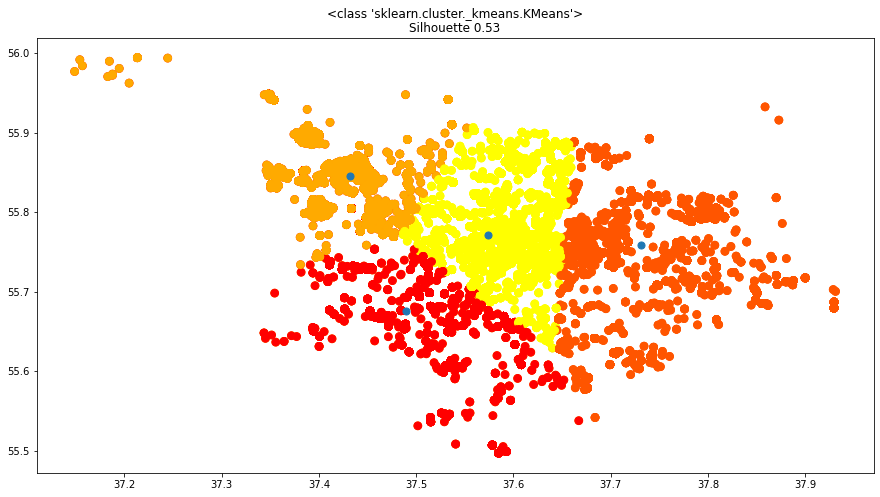

In [13]:
%%time
kmeans = KMeans(n_clusters=4)
kmeans.fit(geo[['x', 'y']])
# Теперь сделаем случайное предсказание:
clusters_predict = kmeans.predict(geo[['x', 'y']])

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(geo['x'], geo['y'], c=clusters_predict, cmap='autumn', s=60)
ax.set_title(get_descr("KMeans",clusters_predict, geo[['x', 'y']]))

# кластеризуем и выводим картинку
clusters = kmeans.fit_predict(geo[['x', 'y']])
ax.scatter(geo['x'], geo['y'], c=clusters, cmap='autumn', s=60)
ax.set_title(get_descr(KMeans, clusters, geo[['x', 'y']]))

# выводим центры кластеров
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], s=50)

В принципе, столицу действительно можно поделить так: на северную часть (с центральной), западную (с самой большой дисперсией), восточную (наиболее обширную) и южную (немного скошенную на запад). При этом стоит отметить, что silhouette_score уменьшился. Поэтому построим еще раз, но уже с 8 кластерами:

CPU times: user 19min 24s, sys: 2h 19min 31s, total: 2h 38min 55s
Wall time: 11min 19s


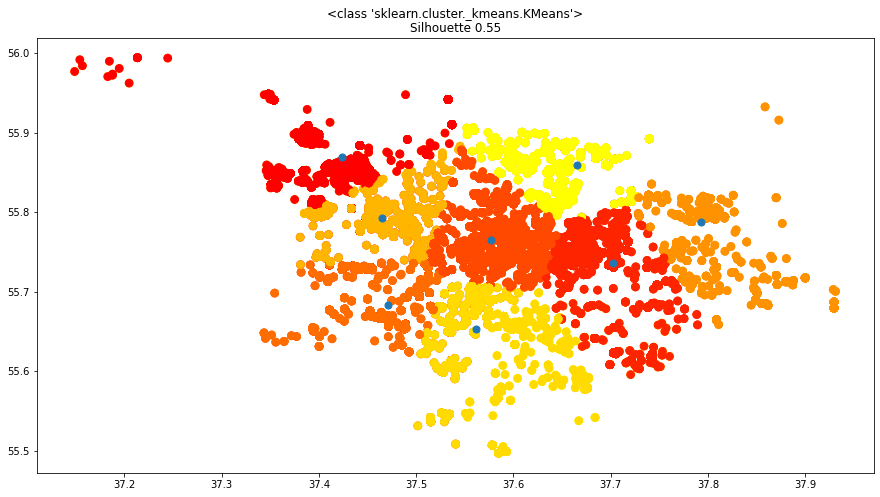

In [14]:
%%time
kmeans = KMeans(n_clusters=8)
kmeans.fit(geo[['x', 'y']])
# Теперь сделаем случайное предсказание:
clusters_predict = kmeans.predict(geo[['x', 'y']])

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(geo['x'], geo['y'], c=clusters_predict, cmap='autumn', s=60)
ax.set_title(get_descr("KMeans",clusters_predict, geo[['x', 'y']]))

# кластеризуем и выводим картинку
clusters = kmeans.fit_predict(geo[['x', 'y']])
ax.scatter(geo['x'], geo['y'], c=clusters, cmap='autumn', s=60)
ax.set_title(get_descr(KMeans, clusters, geo[['x', 'y']]))

# выводим центры кластеров
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], s=50)

А показатель Silhouette вырос на 0,02. Значит, эта разбивка и правда лучше.  
Идём дальше.

Задание 2:  
***Исследовать скопления голосов за и против отдельно***

Для начала посмотрим на распределение значений целевой переменной:

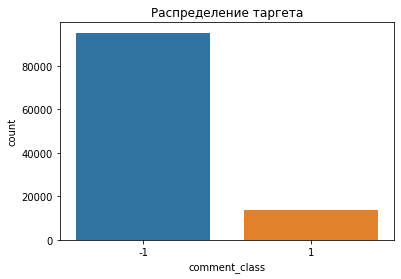

In [15]:
ax = plt.axes()
sns.countplot('comment_class', data=geo, ax=ax)
ax.set_title("Распределение таргета")
plt.show()

Однако мало людей позитивно отнеслось к застройке своего района. Какие районы проголосовали активнее всего? 

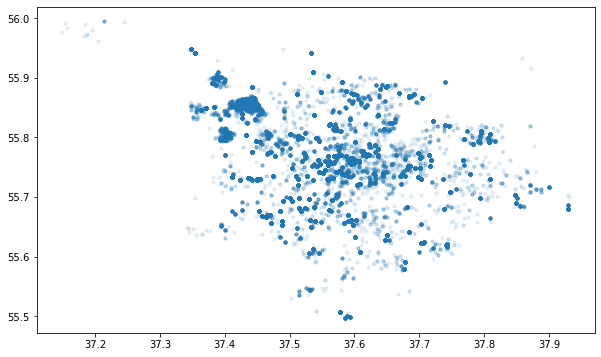

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(geo['x'], geo['y'], s=10, alpha=0.1)

Больше всего закрашен северо-запад столицы. Менее - восток и юго-восток.

А теперь посмотрим, какие из этих точек имеют позитивную оценку, а какие - негативную:

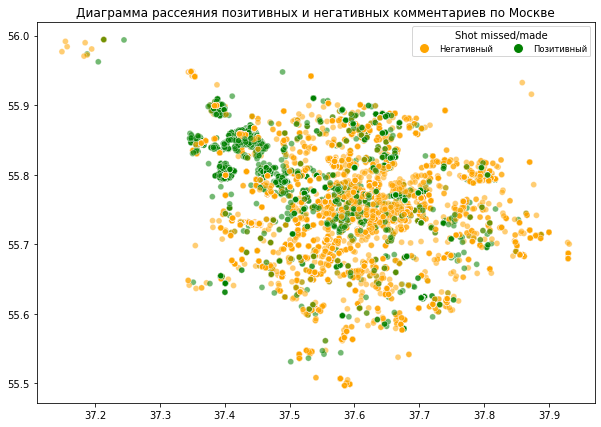

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

scatter = sns.scatterplot(geo["x"], geo["y"], hue=geo['comment_class'], alpha=0.55, ax=ax, palette=["orange", 'green'])

ax.set_title("Диаграмма рассеяния позитивных и негативных комментариев по Москве")
ax.set_xlabel("")
ax.set_ylabel("")
legend_elemnts = [Line2D([0], [0], marker="o", color='w', label="Негативный",
                         markerfacecolor="orange", markersize=10),
                  Line2D([0], [0], marker="o", color='w', label="Позитивный",
                         markerfacecolor="green", markersize=10)]
plt.legend(handles=legend_elemnts, title="Shot missed/made", 
           ncol=2, fontsize='small', fancybox=True)

Теперь видно, что согласных больше в левой верхней части диаграммы (Северо-Запад Москвы). На юге, востоке и юго-востоке больше несогласных, чем согласных. Получается, в этих района людей проголосовало меньше, но ответы были с негативной окраской.

Теперь посмотрим отдельно голоса "за" и "против":

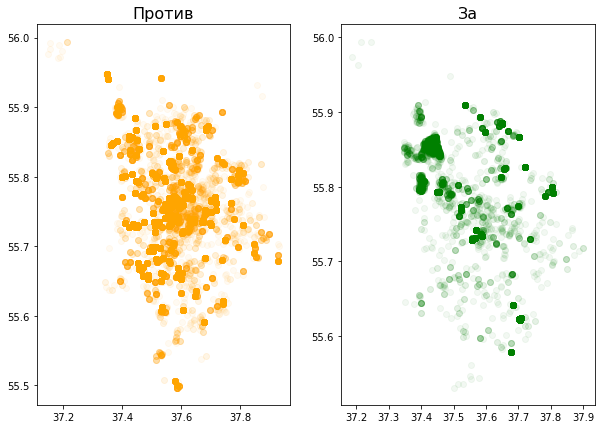

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))

ax1.scatter(x=geo[geo['comment_class'] == -1].x, y=geo[geo['comment_class'] == -1].y, alpha=0.05, color='orange')
ax2.scatter(x=geo[geo['comment_class'] == 1].x, y=geo[geo['comment_class'] == 1].y, alpha=0.05, color='g')

titles = ["Против", "За"]
colors = ["orange", "g"]

for number, title in zip (fig.axes, titles):
    number.set_title(title, fontsize=16)

Итак: "против" активнее всего голосовали в центре, а "за" - на севере, в особенности, как упоминалось выше, на северо-западе столицы.

Теперь сделаем срезы по таргету из нашей выборки: отдельно для голосов "за" и отдельно для "против". Обучим модель и посмотрим оптимальное количество кластеров для них.  
    А чтобы не дублировать код - напишем функцию для обучения модели и для выявления подходящего количества кластеров:

In [19]:
def fitting_kmeans(df, n):
    model = KMeans(n_clusters=n)
    model.fit(df[['x', 'y']])
    # Теперь сделаем предсказание:
    clusters_pred = model.predict(df[['x', 'y']])
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    ax.scatter(df['x'], df['y'], c=clusters_pred, cmap='autumn', s=60)
    ax.set_title(get_descr("KMeans",clusters_pred, df[['x', 'y']]))

    # кластеризуем и выводим картинку
    clusters = model.fit_predict(df[['x', 'y']])
    ax.scatter(df['x'], df['y'], c=clusters, cmap='autumn', s=60)
    ax.set_title(get_descr(KMeans, clusters, df[['x', 'y']]))

    # выводим центры кластеров    
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s=50)
    plt.show()

In [20]:
def find_optimal_k(df, start, stop):
    k_inertia = []
    ks = range(start, stop)

    for k in ks:
        clf_kmeans = KMeans(n_clusters=k)
        clusters_kmeans = clf_kmeans.fit_predict(df[['x', 'y']])
        k_inertia.append(clf_kmeans.inertia_)
    diff = np.diff(k_inertia)
    diff_r = diff[1:] / diff[:-1]
    k_opt = ks[np.argmin(diff_r)+1]
    return k_opt

<u/>Вызываем функции для среза "против":</u>

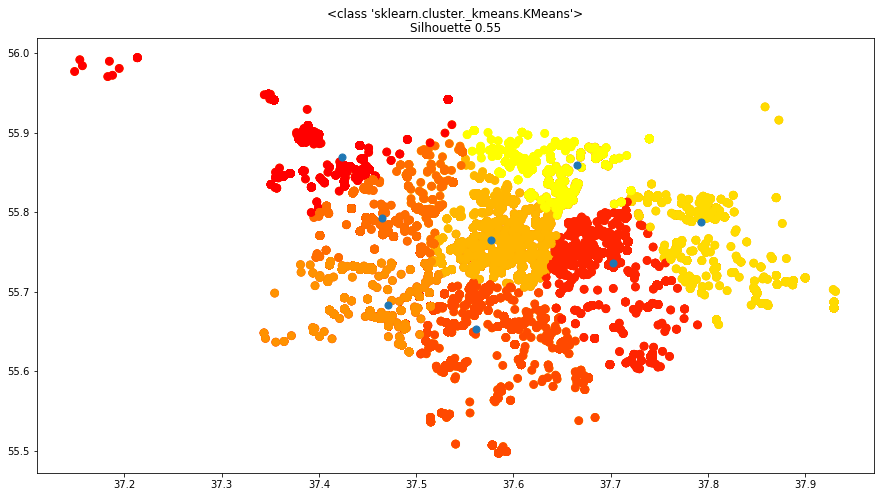

In [21]:
df_neg = geo[geo['comment_class'] == -1]
fitting_kmeans(df_neg, 8)

Для отрицательных ответов модель так же выделила 4 кластера:

In [22]:
find_optimal_k(df_neg, 1, 20)

4

Построим для них гистограмму:

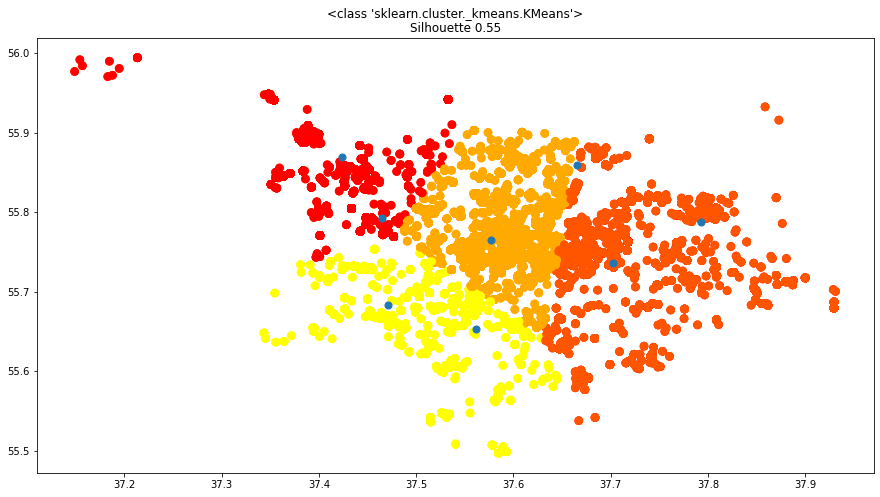

In [23]:
fitting_kmeans(df_neg, 4)

<u/>И то же самое для среза "за":</u>

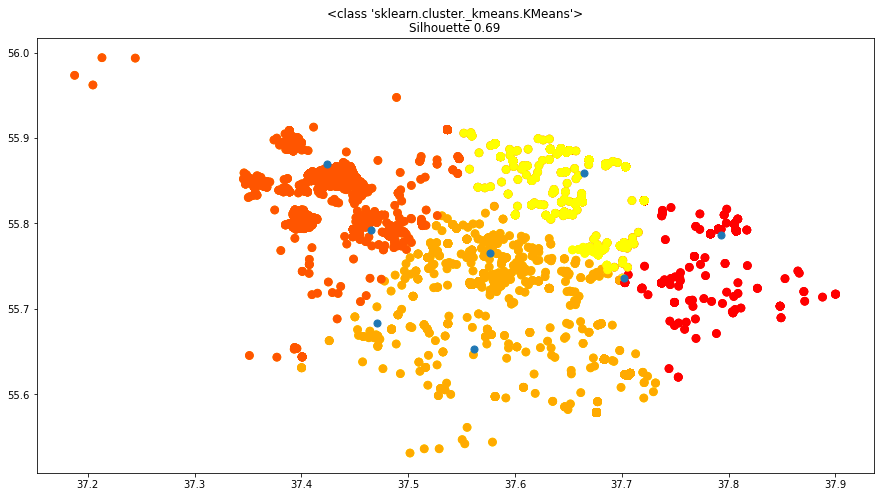

In [24]:
df_pos = geo[geo['comment_class'] == 1]
fitting_kmeans(df_pos, 4)  # ночнём с 4, т.к. самих ответов на порядок меньше

In [25]:
find_optimal_k(df_pos, 1, 20)

5

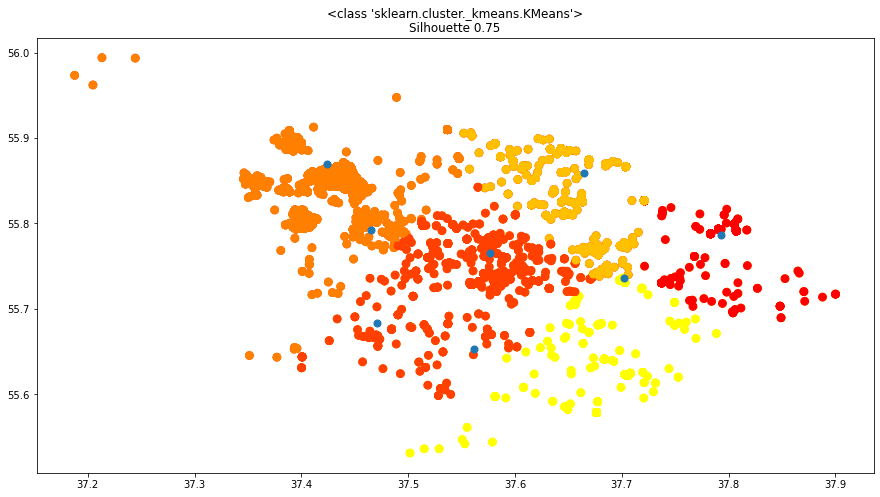

In [26]:
fitting_kmeans(df_pos, 5)

Итак, для отрицательных ответов модель разделила город на 4 кластера. Для положительных ответов - на 5. Также стоит заметить, что Silhoette при правильно подобранном количестве кластеров стал выше первоначального для выборки "за" и остался на прежнем уровне для "против".

Дополнительное задание:  
***Найти наиболее активные в голосовании районы (подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')***

Для наилучшего определения наиболее активных в голосовании районов разделим датасет на 3 части и прогоним первую в цикле, где переберем параметры модели: "eps" и "min_samples".

In [27]:
geo.shape

(108806, 4)

In [28]:
geo1 = geo[geo.index < 30000]
geo2 = geo[(geo.index >= 30000) & (geo.index < 70000)]
geo3 = geo[geo.index >70000]
geo1.shape, geo2.shape, geo3.shape

((30000, 4), (40000, 4), (38805, 4))

eps: 0.02, min_samples: 10, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.48


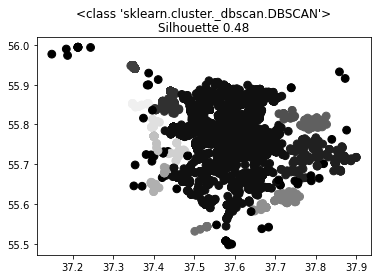

eps: 0.02, min_samples: 50, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.50


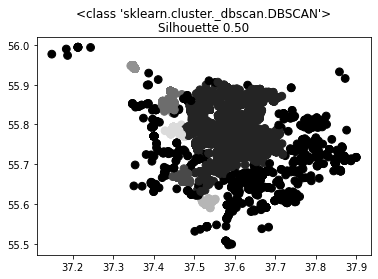

eps: 0.02, min_samples: 100, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.49


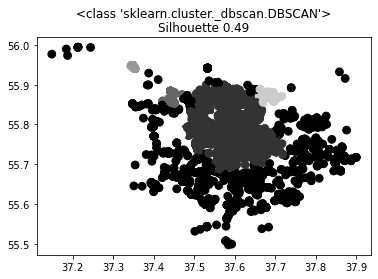

eps: 0.02, min_samples: 200, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.53


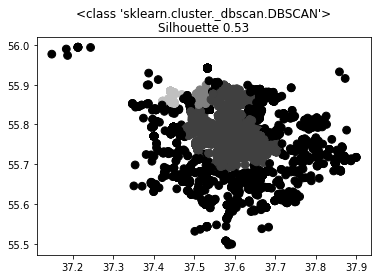

eps: 0.02, min_samples: 300, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.47


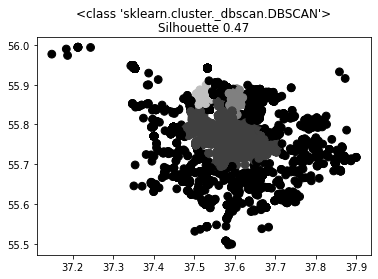

eps: 0.02, min_samples: 500, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.41


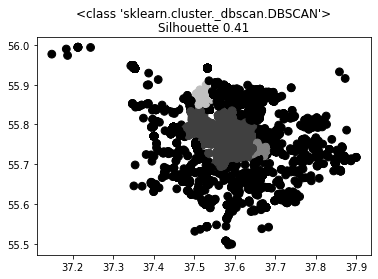

eps: 0.02, min_samples: 1000, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.50


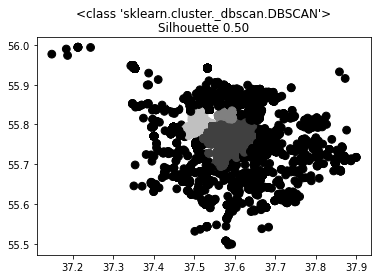

eps: 0.1, min_samples: 10, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.61


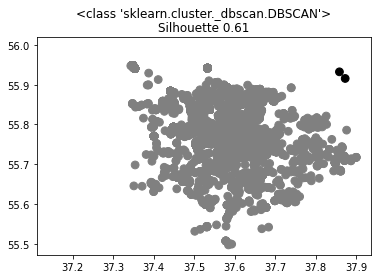

eps: 0.1, min_samples: 50, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.69


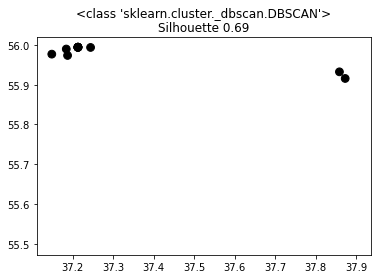

eps: 0.1, min_samples: 100, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.69


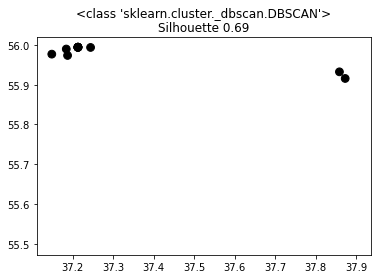

eps: 0.1, min_samples: 200, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.69


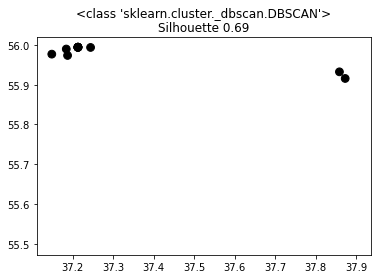

eps: 0.1, min_samples: 300, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.70


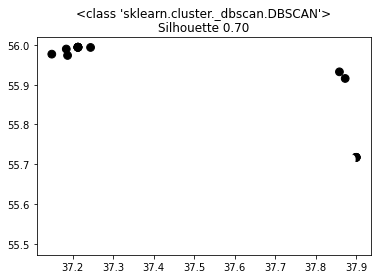

eps: 0.1, min_samples: 500, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.68


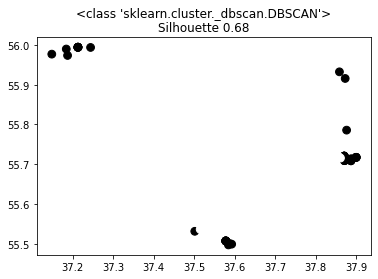

eps: 0.1, min_samples: 1000, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


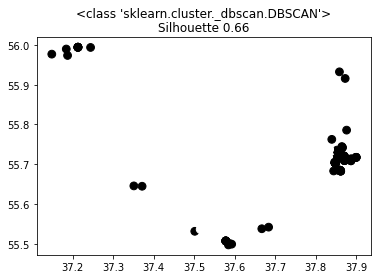

Only one label
eps: 0.5, min_samples: 10, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


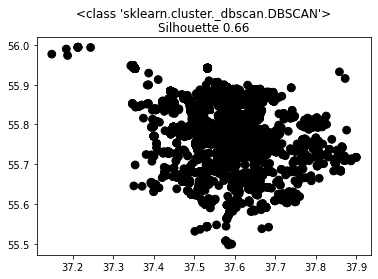

Only one label
eps: 0.5, min_samples: 50, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


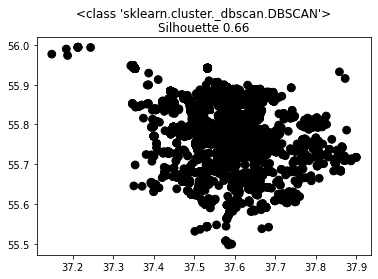

Only one label
eps: 0.5, min_samples: 100, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


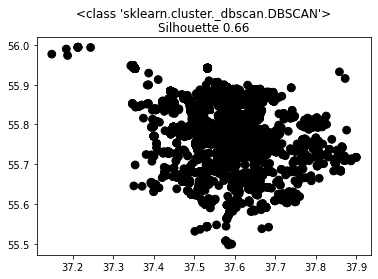

Only one label
eps: 0.5, min_samples: 200, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


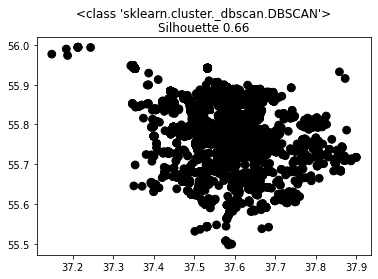

Only one label
eps: 0.5, min_samples: 300, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


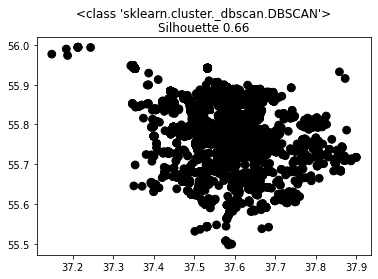

Only one label
eps: 0.5, min_samples: 500, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


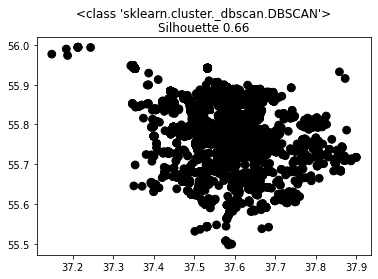

Only one label
eps: 0.5, min_samples: 1000, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


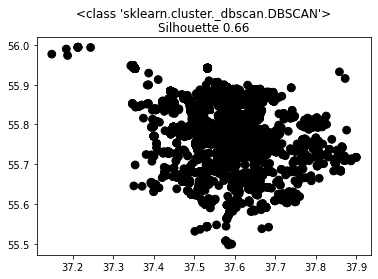

Only one label
eps: 0.8, min_samples: 10, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


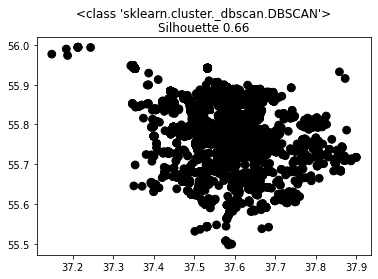

Only one label
eps: 0.8, min_samples: 50, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


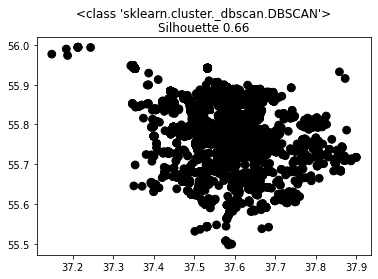

Only one label
eps: 0.8, min_samples: 100, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


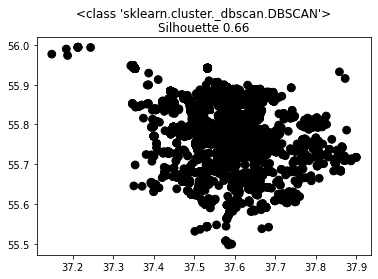

Only one label
eps: 0.8, min_samples: 200, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


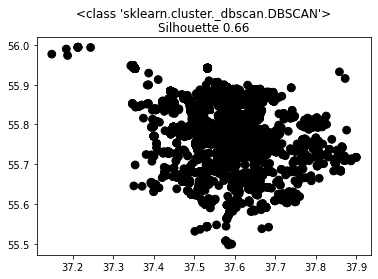

Only one label
eps: 0.8, min_samples: 300, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


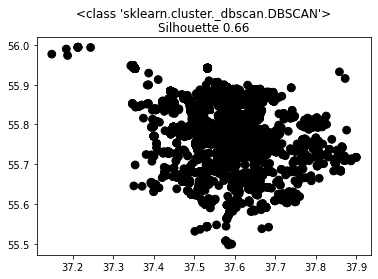

Only one label
eps: 0.8, min_samples: 500, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


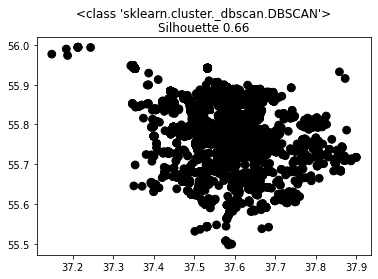

Only one label
eps: 0.8, min_samples: 1000, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


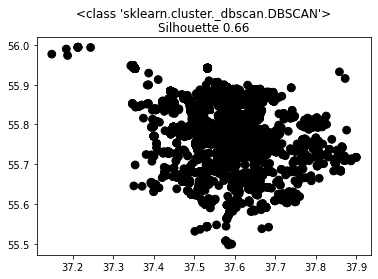

Only one label
eps: 1, min_samples: 10, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


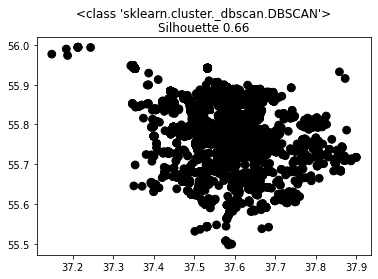

Only one label
eps: 1, min_samples: 50, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


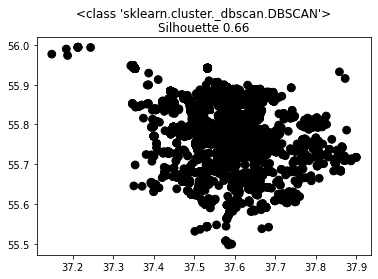

Only one label
eps: 1, min_samples: 100, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


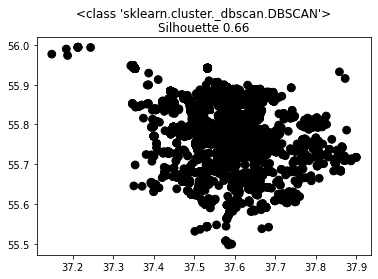

Only one label
eps: 1, min_samples: 200, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


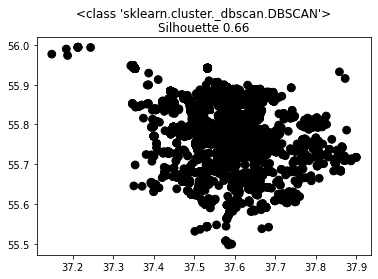

Only one label
eps: 1, min_samples: 300, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


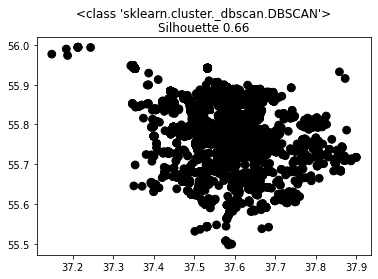

Only one label
eps: 1, min_samples: 500, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


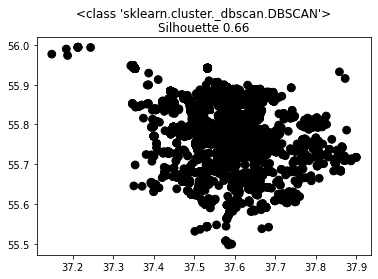

Only one label
eps: 1, min_samples: 1000, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


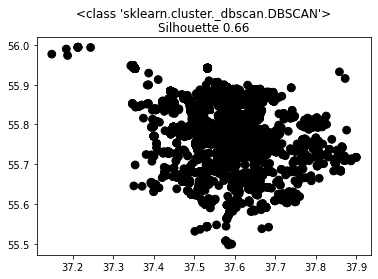

Only one label
eps: 2, min_samples: 10, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


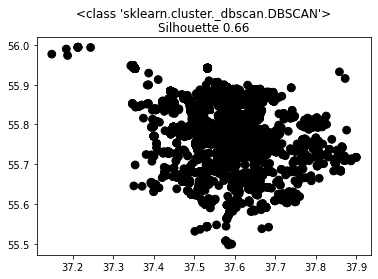

Only one label
eps: 2, min_samples: 50, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


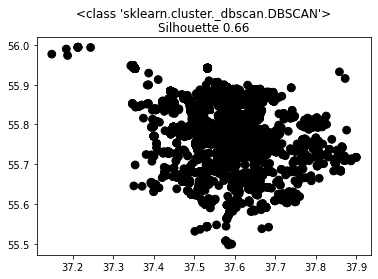

Only one label
eps: 2, min_samples: 100, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


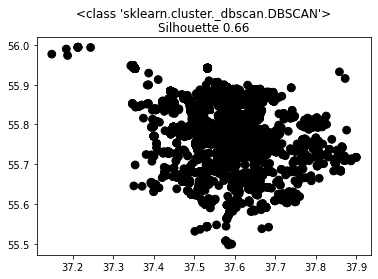

Only one label
eps: 2, min_samples: 200, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


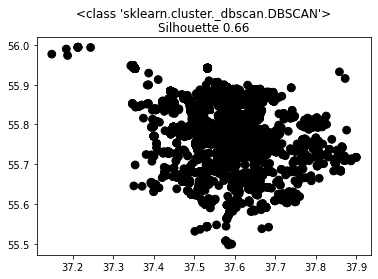

Only one label
eps: 2, min_samples: 300, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


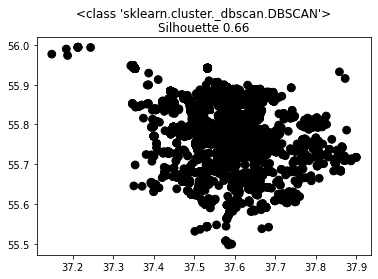

Only one label
eps: 2, min_samples: 500, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


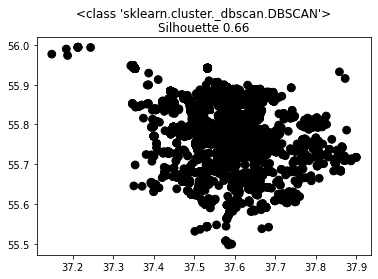

Only one label
eps: 2, min_samples: 1000, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


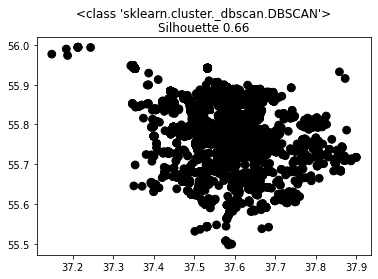

Only one label
eps: 3, min_samples: 10, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


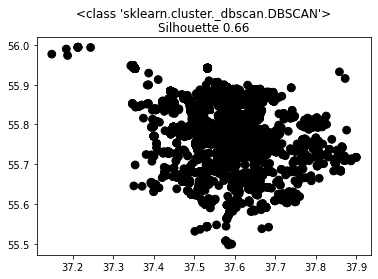

Only one label
eps: 3, min_samples: 50, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


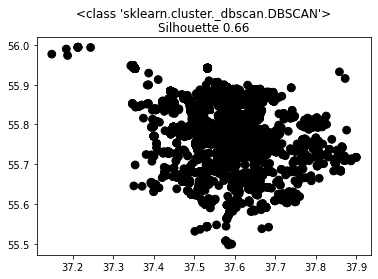

Only one label
eps: 3, min_samples: 100, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


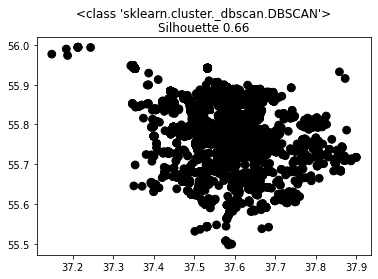

Only one label
eps: 3, min_samples: 200, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


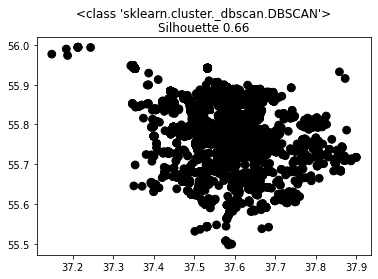

Only one label
eps: 3, min_samples: 300, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


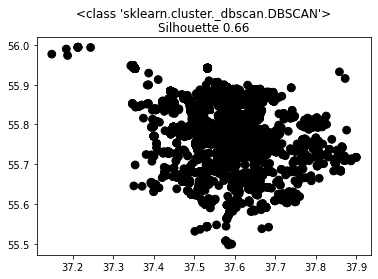

Only one label
eps: 3, min_samples: 500, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


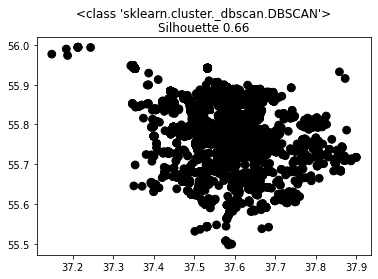

Only one label
eps: 3, min_samples: 1000, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.66


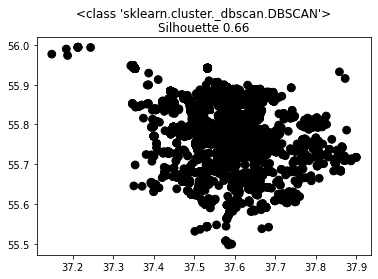

CPU times: user 21min, sys: 1h 21min 10s, total: 1h 42min 11s
Wall time: 14min 10s


In [29]:
%%time

eps_all = [0.02, 0.1, 0.5, 0.8, 1, 2, 3]
min_samples_all = [10, 50, 100, 200, 300, 500, 1000]
answer = []

for eps in eps_all:
    for min_samples in min_samples_all:
        
        db_scan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        clusters1 = db_scan.fit_predict(geo1[['x', 'y']])
        ax.scatter(geo1['x'], geo1['y'], c=clusters1, cmap='gray', s=60)
        try:
            silhouette = get_descr(DBSCAN, clusters1, geo1[['x', 'y']])
        except ValueError:
            print('Only one label')
        ax.set_title(silhouette)
        print("eps: {}, min_samples: {}, silhouette: {}".format(eps, min_samples, silhouette))
        answer.append([eps, min_samples, silhouette])
        plt.show()
        

In [30]:
answer

[[0.02, 10, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.48"],
 [0.02, 50, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.50"],
 [0.02, 100, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.49"],
 [0.02, 200, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.53"],
 [0.02, 300, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.47"],
 [0.02, 500, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.41"],
 [0.02, 1000, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.50"],
 [0.1, 10, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.61"],
 [0.1, 50, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.69"],
 [0.1, 100, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.69"],
 [0.1, 200, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.69"],
 [0.1, 300, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.70"],
 [0.1, 500, "<class 'sklearn.cluster._dbscan.DBSCAN'>\nSilhouette 0.68"],
 [0.1, 1000, "<class 'sklearn.clus

Итак, показатель Silhouette оптимальнее всего при eps=0.02 и min_samples=200. Возьмем этот вариант, т.к. в остальных случаях, где показатель выше, прослеживается только один кластер.

eps: 3, min_samples: 1000, silhouette: <class 'sklearn.cluster._dbscan.DBSCAN'>
Silhouette 0.53


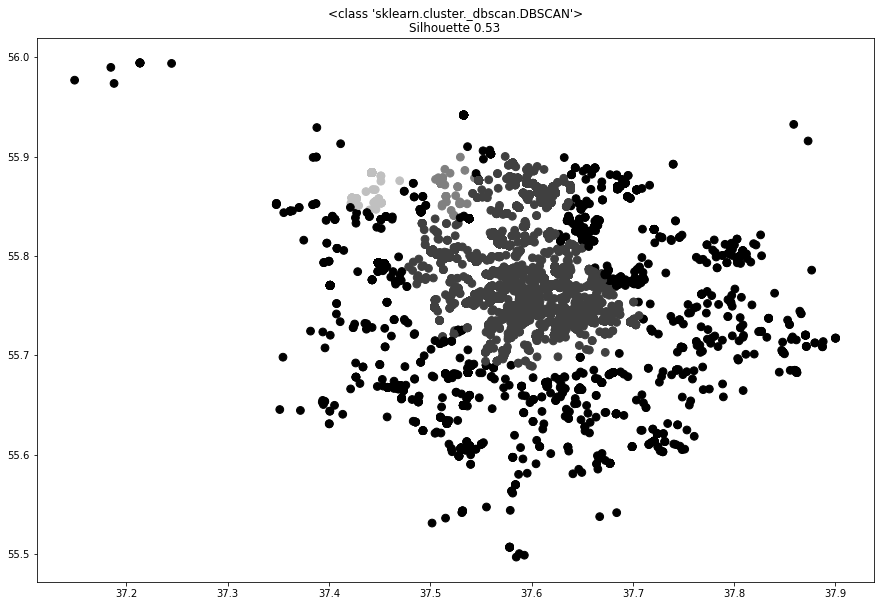

In [31]:
db_scan = DBSCAN(eps=0.02, min_samples=200, n_jobs=-1)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
clusters1 = db_scan.fit_predict(geo1[['x', 'y']])
ax.scatter(geo1['x'], geo1['y'], c=clusters1, cmap='gray', s=60)
try:
    silhouette = get_descr(DBSCAN, clusters1, geo1[['x', 'y']])
except ValueError:
    print('Only one label')
ax.set_title(silhouette)
print("eps: {}, min_samples: {}, silhouette: {}".format(eps, min_samples, silhouette))
answer.append([eps, min_samples, silhouette])
plt.show()

Что мы видим: черным высвечиваются не плотные районы, значит, наиболее активные районы - центр, север и северо-восток. И это не удивительно, т.к. еще на первых наших картинках видно, что более плотное окрашивание приходится именно на эти районы.

Дополнительное задание:  
***Выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию***

Открываем датафрейм "geo_comment"

In [32]:
geo_comment.head()

,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [33]:
geo_comment['comment'][0]

'Во все разделы правил землепользования и застройки г.Москвы (текстовые части и\xa0графические схемы) необходимо внести изменения по земельному участку с кадастровым\xa0номером 77:01:0004002:188 с адресом первый Самотёчный пер., вл. 17Б (в ПЗЗ\xa0территориальная зона №2034561) и исключить из этого земельного участка часть моей\xa0общей долевой собственности - земельного участка многоквартирного дома 17А по 1-му\xa0Самотёчному пер. площадью 650,5 кв.м с точками 1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-1 с\xa0координатами: 12316.39 и 6983.68; 123224 6988.91; 12316,45 и 7009,60; 12328.04 и\xa07013.46;12327.73 и 7014.41; 12330.06 и 7015.18; 12330.37 и 7014.24; 12335.17 и 7015.83;\xa012330.82 и 7028.61; 12304.74 и 7021.28; 12302.02 и 7012.47; 12303.22 и 7005.49; 12297.24 и\xa07004.18; 12297ю96 и 7000.60; 12311.23 и 7003.64; 12316.39 и 6983.68. - На основании\xa0вступившего в законную силу судебного решения по делу № А40-51937/2011 от 11.06.2015 о\xa0ничтожности заключённого 18.06.2007 договор

In [34]:
corpus = list(geo_comment['comment'])

In [35]:
def lemmatize(text):      # лемматизируем текст и объединим элементы списка в строку, которую получим на выходе
    m = Mystem()
    lemm_text = []
    for row in text:
        lemmas = ' '.join(m.lemmatize(row))
        lemm_text.append(lemmas)
    return (pd.Series(lemm_text))


def clear_text(text):     # очистим строки при помощи регулярных выражений: оставим только буквы.
    new_text = (re.sub(r'[^а-яА-Я]', ' ', text)).lower()
    return " ".join(new_text.split())

In [36]:
%%time
clear_lst = []
for i in corpus:
    clear_lst.append(clear_text(i))
clear_lst[:5]

CPU times: user 24.3 s, sys: 743 ms, total: 25 s
Wall time: 26.3 s


['во все разделы правил землепользования и застройки г москвы текстовые части и графические схемы необходимо внести изменения по земельному участку с кадастровым номером с адресом первый самот чный пер вл б в пзз территориальная зона и исключить из этого земельного участка часть моей общей долевой собственности земельного участка многоквартирного дома а по му самот чному пер площадью кв м с точками с координатами и и и и и и и и и и и и ю и и и на основании вступившего в законную силу судебного решения по делу а от о ничтожности заключ нного договора аренды земельного участка с адресными ориентирами й самот чный пер вл б и кадастровым номером',
 'на основании вступившего в законную силу судебного решения по делу а от о ничтожности заключ нного договора аренды земельного участка с адресными ориентирами й самот чный пер вл б и кадастровым номером необходимо внести все соответствующие изменения и исключить мою собственность площадью кв м из земельного участка вл б по му самот чному пер по

In [37]:
%%time
geo_comment['lemm_text'] = lemmatize(clear_lst)
geo_comment.head()

CPU times: user 3min 40s, sys: 16.6 s, total: 3min 56s
Wall time: 26min 7s


,Unnamed: 0,x,y,comment_class,multiplier,comment,lemm_text
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...,во весь раздел правило землепользовани...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...,на основание вступать в законный сил...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...,вносить в проект правило землепользова...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...,учитывать социальный значимость проект ...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...,учитывать социальный значимость проект ...


Далее преобразуем слова в векторы и оценим важность слов, но сначала перезапишем в переменную "corpus" уже обработанные строки, находящиеся в столбце "lemm_text":

In [38]:
corpus = list(geo_comment['lemm_text']) 

Чтобы почистить мешок слов, найдём стоп-слова:

In [39]:
stop_words = set(stopwords.words('russian'))

Оценим важность слов: определим, как часто уникальное слово встречается во всём корпусе и в отдельном его тексте:

In [40]:
voc = TfidfVectorizer(stop_words=stop_words).fit(corpus)
imp_words = voc.transform(corpus)
imp_words.shape

(70382, 14843)

Далее построим кластеры и ответим на вопрос: какие же темы чаще всего затрагивались в комментариях.  
Для этого посчитаем, сколько кластеров необходимо создать:

In [41]:
k_inertia = []
ks = range(1, 20)
for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(imp_words)
    k_inertia.append(clf_kmeans.inertia_)
diff = np.diff(k_inertia)
diff_r = diff[1:] / diff[:-1]
k_opt = ks[np.argmin(diff_r)+1]
k_opt

12

Тем не менее постфактум оказалось, что самый оптимальный вариант - 8 кластеров. Поэтому поставим 8.

Запускаем процесс кластеризации:

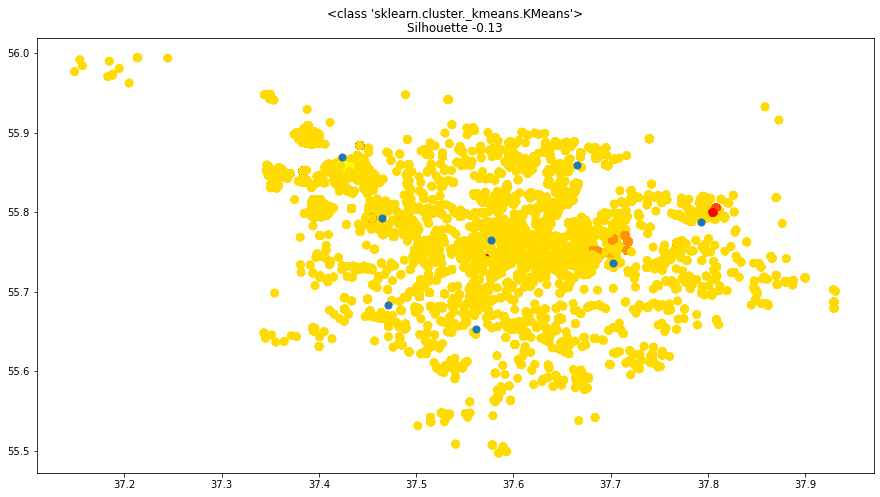

CPU times: user 10min 31s, sys: 56min 36s, total: 1h 7min 7s
Wall time: 5min 51s


In [42]:
%%time
model = KMeans(n_clusters=8)
model.fit(imp_words)
# Теперь сделаем случайное предсказание:
clusters_pred = model.predict(imp_words)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(geo_comment['x'], geo_comment['y'], c=clusters_pred, cmap='autumn', s=60)
ax.set_title(get_descr("KMeans",clusters_pred, geo_comment[['x', 'y']]))

# кластеризуем и выводим картинку
clusters = model.fit_predict(imp_words)
ax.scatter(geo_comment['x'], geo_comment['y'], c=clusters, cmap='autumn', s=60)
ax.set_title(get_descr(KMeans, clusters, geo_comment[['x', 'y']]))

# выводим центры кластеров    
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], s=50)
plt.show()

Создадим новый датафрейм, куда внесем получившиеся результаты вместе с номерами кластеров:

In [43]:
cluster_map = pd.DataFrame()
cluster_map['geo_index'] = geo_comment.index.values
cluster_map['comments'] = geo_comment.comment
cluster_map['cluster'] = model.labels_

cluster_map.head()

,geo_index,comments,cluster
0,0,Во все разделы правил землепользования и застр...,6
1,1,На основании вступившего в законную силу судеб...,6
2,2,Внести в Проект правил землепользования и заст...,6
3,3,Учитывая социальную значимость проекта строите...,6
4,4,Учитывая социальную значимость проекта строите...,6


Проверим, какие получились значения:

In [44]:
cluster_map['cluster'].value_counts()

6    33582
1     7324
5     6983
0     5604
4     5367
2     4688
3     4554
7     2280
Name: cluster, dtype: int64

Итак, забегая вперед, напишу, какие темы наиболее часто повторяются в столбце с комментариями в данном датасете:    
    - **1 кластер**: незаконная застройка  
    - **2 кластер**: обсуждение территории производственной зоны № 23  
    - **3 кластер**: обсуждение транспортно-пересадочного узла  
    - **4 кластер**: заявления жителей Лефортово (против стоительства различных объектов)  
    - **5 кластер**: заявления жителей Северное Измайлово (согласие на строительство нового дома)      
    - **6 кластер**: попала вся "сборная солянка", которую трудно отнести к остальным, весьма конкретным, кластерам  
    - **7 кластер**: заявления об отклонении представленного на судебные слушания проекта  
    - **0 кластер**: вопрос строительства гаража на придомовой территории  

Как всё это проверялось (на примере кластера 4):

In [45]:
cluster_map[cluster_map['cluster'] == 4]

,geo_index,comments,cluster
39262,39262,"Мы, жители района Лефортово, категорически воз...",4
39263,39263,"Мы, жители района Лефортово, категорически воз...",4
39264,39264,"Мы, жители района Лефортово, категорически воз...",4
39265,39265,"Мы, жители района Лефортово, категорически воз...",4
39266,39266,"Мы, жители района Лефортово, категорически воз...",4
...,...,...,...
46350,46350,"Мы, жители района Лефортово, категорически воз...",4
46351,46351,"Мы, жители района Лефортово, категорически воз...",4
46352,46352,"Мы, жители района Лефортово, категорически воз...",4
46353,46353,"Мы, жители района Лефортово, категорически воз...",4


In [46]:
cluster_map[(cluster_map['cluster'] == 4) & (cluster_map['geo_index'] == 39262)]['comments'].tolist()

['Мы, жители района Лефортово, категорически возражаем против строительства гостиницы по адресу Золоторожский вал, вл.16, против оформления любых документов для строительства гостиницы по этому адресу, в том числе против оформления градостроительного плана земельного участка для строительства гостиницы по данному адресу. Мы требуем отмены всех документов, допускающих строительство гостиницы по адресу.\nМы требуем выделить земельный участок по адресу Золоторожский вал, 16, под\xa0размещение ПЛОСКОСТНЫХ спортивных объектов, объектов благоустройства и озеленения (в том числе плоскостных автостоянок),  без размещения на данном земельном участке любых объектов капитального строительства.\xa0Мы, жители района Лефортово, категорически возражаем против строительства гостиницы по адресу Золоторожский вал, вл.16, против оформления любых документов для строительства гостиницы по этому адресу, в том числе против оформления градостроительного плана земельного участка для строительства гостиницы по 

In [47]:
cluster_map[(cluster_map['cluster'] == 4) & (cluster_map['geo_index'] == 46354)]['comments'].tolist()

['Мы, жители района Лефортово, категорически возражаем против любого нового капитального строительства по адресу Солдатский переулок, 26 (земельные участки кадастровыми номерами 77:04:0001001:221, 77:04:0001001:222). Мы требуем отменить все документы, допускающие новое капитальное строительство на данных земельных участках.\nМы требуем выдать для территории, которую занимают данные земельные участки, документы, допускающие исключительно благоустройство и озеленение данной территории, и разместить на этой территории плоскостные спортивные объекты и объекты озеленения.']

Сравним с изначальным фреймом (перепроверим, не случилось ли перекоса):

In [48]:
geo_comment[geo_comment.index == 39262]['comment'].tolist()

['Мы, жители района Лефортово, категорически возражаем против строительства гостиницы по адресу Золоторожский вал, вл.16, против оформления любых документов для строительства гостиницы по этому адресу, в том числе против оформления градостроительного плана земельного участка для строительства гостиницы по данному адресу. Мы требуем отмены всех документов, допускающих строительство гостиницы по адресу.\nМы требуем выделить земельный участок по адресу Золоторожский вал, 16, под\xa0размещение ПЛОСКОСТНЫХ спортивных объектов, объектов благоустройства и озеленения (в том числе плоскостных автостоянок),  без размещения на данном земельном участке любых объектов капитального строительства.\xa0Мы, жители района Лефортово, категорически возражаем против строительства гостиницы по адресу Золоторожский вал, вл.16, против оформления любых документов для строительства гостиницы по этому адресу, в том числе против оформления градостроительного плана земельного участка для строительства гостиницы по 

In [49]:
geo_comment[geo_comment.index == 46354]['comment'].tolist()

['Мы, жители района Лефортово, категорически возражаем против любого нового капитального строительства по адресу Солдатский переулок, 26 (земельные участки кадастровыми номерами 77:04:0001001:221, 77:04:0001001:222). Мы требуем отменить все документы, допускающие новое капитальное строительство на данных земельных участках.\nМы требуем выдать для территории, которую занимают данные земельные участки, документы, допускающие исключительно благоустройство и озеленение данной территории, и разместить на этой территории плоскостные спортивные объекты и объекты озеленения.']

И выведем, например, диапазон значений:

In [50]:
geo_comment[46344:46354]

,Unnamed: 0,x,y,comment_class,multiplier,comment,lemm_text
46344,46344,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46345,46345,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46346,46346,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46347,46347,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46348,46348,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46349,46349,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46350,46350,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46351,46351,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46352,46352,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...
46353,46353,37.702751,55.76639,-1,1,"Мы, жители района Лефортово, категорически воз...",мы житель район лефортово категорическ...


Действительно, комментарии те же и класс комментариев отрицательный.

### Вывод

Таким образом, в данной работе были выполнены несколько заданий: как обязательные, так и дополнительные.  
Среди обязательных заданий выполнены:

    1) визуальное разделение города на районы безотносительно голосов (проведена кластеризация и выведена картинка). В результате наиболее подходящим оказалось разделение города на 8 кластеров.  
    2) по аналогии исследованы скопления голосов "за" и "против" отдельно. В ходе анализа выяснилось, что голосов "против" намного больше, при этом положительных голосов много на северо-западе Москвы.   
    3) подобрано оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально). Это было сделано еще в первом задании. По результатам работы функции перебора наилучший результат стал 4 кластера, однако  оптимальное число всё же, на наш взгляд, 8.

Среди дополнительных заданий:

    1) найдены наиболее активные в голосовании районы (ими оказались центр, север и свеверо-запад)  
    2) выделены основные тематики комментариев жителей: 
            - строительство транспортного узла
            - освоение территории производственной зоны №23
            - согласие на строительство дома на территории Северного Измайлово
            - комментарии против застройки Лефортово
            - незаконная застройка
            - отклонение проекта на судебном слушании
            - строительство гаража
            
В ходе выполнения проекта была освоена тема кластеризации, а также работа с текстами.  
Все задачи выполнены.